In [1]:
from tiatoolbox.tools import stainnorm
import openslide
import cv2
# import torch
from torchvision import transforms
# import torchstain
from matplotlib import pyplot as plt
import numpy as np

|2023-12-18|10:35:57.660| [INFO] Note: detected 80 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
|2023-12-18|10:35:57.661| [INFO] Note: NumExpr detected 80 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
|2023-12-18|10:35:57.662| [INFO] NumExpr defaulting to 8 threads.


In [ ]:
# Paths to your .svs files
target_path = "/tank/WSI_data/Ovarian_WSIs/TCGA-OV/slides/TCGA-23-1027-01Z-00-DX1.53F9DFF4-6811-4184-B2FD-1F6706B948FD.svs"
source_path = "/tank/WSI_data/Ovarian_WSIs/BRCA_blind_test/slides/SZ10091_22-1-16-1.mrxs"

# Load images using OpenSlide
target_slide = openslide.OpenSlide(target_path)
source_slide = openslide.OpenSlide(source_path)


patch_size = (256, 256)  # You can adjust the size as needed

# Get dimensions of the slide at level 0
slide_width, slide_height = source_slide.dimensions
# Randomly select a top-left point for the patch
x = np.random.randint(100, slide_width - patch_size[0])
y = np.random.randint(100, slide_height - patch_size[1])
# Extract the patch
source_image = source_slide.read_region((x, y), 0, patch_size)
# Extract level 0 image
target_image = target_slide.read_region((0, 0), 2, target_slide.level_dimensions[2])

# norm many patches.

# Convert to RGB format
target_image = cv2.cvtColor(np.array(target_image), cv2.COLOR_RGBA2RGB)
source_image = cv2.cvtColor(np.array(source_image), cv2.COLOR_RGBA2RGB)

# Your existing code for normalization
T = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x*255)
])
normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
normalizer.fit(T(target_image))
t_source_image = T(source_image)
norm, H, E = normalizer.normalize(I=t_source_image, stains=True)


In [ ]:
plt.figure(figsize=(18, 6))

# Plot the target image
plt.subplot(1, 3, 1)
plt.imshow(target_image)
plt.title('Target Image')

# Plot the source image before normalization
plt.subplot(1, 3, 2)
plt.imshow(source_image)
plt.title('Source Image Before Normalization')

# Plot the source image after normalization
plt.subplot(1, 3, 3)
plt.imshow(norm)
plt.title('Source Image After Normalization')

plt.show()

(5119, 6224, 3)


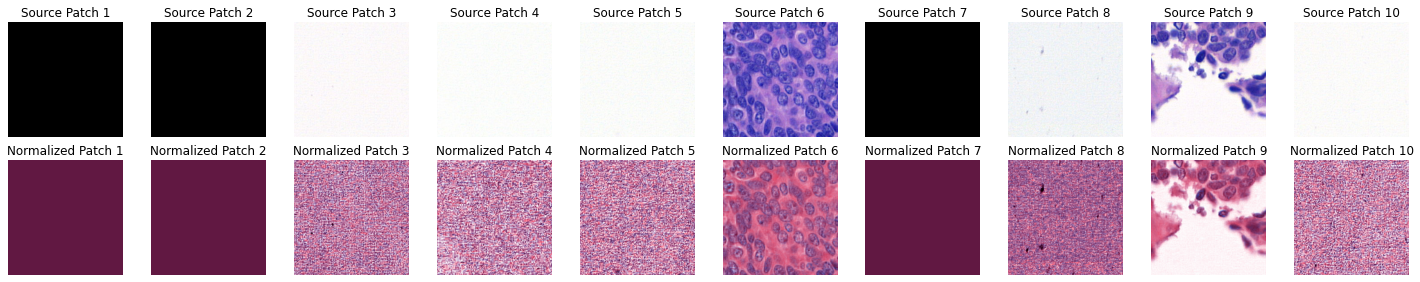

In [13]:
import openslide
import numpy as np
import cv2
import torch
from torchvision import transforms
import torchstain
import matplotlib.pyplot as plt

# Load the target image for normalization reference
target_path = "/tank/WSI_data/Ovarian_WSIs/TCGA-OV/slides/TCGA-23-1027-01Z-00-DX1.53F9DFF4-6811-4184-B2FD-1F6706B948FD.svs"  # Replace with your target WSI path
target_slide = openslide.OpenSlide(target_path)
target_image = target_slide.read_region((0, 0), 2, target_slide.level_dimensions[2])
target_image = np.array(target_image)[:,:,0:3]
print(target_image.shape)

# Load the source slide
source_path = "/tank/WSI_data/Ovarian_WSIs/BRCA_blind_test/slides/SZ10091_22-1-16-1.mrxs"  # Replace with your source WSI path
source_slide = openslide.OpenSlide(source_path)

# Number of patches to visualize
num_patches = 10  # Adjust as needed

# Set the size of the patches
patch_size = (256, 256)

# # Initialize the normalizer
# T = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Lambda(lambda x: x*255)
# ])
# normalizer = torchstain.normalizers.MacenkoNormalizer(backend='torch')
# normalizer.fit(T(target_image))

method_name="Macenko"
stain_normalizer = stainnorm.get_normalizer(method_name)
stain_normalizer.fit(target_image)
# Get dimensions of the source slide at level 0
slide_width, slide_height = source_slide.dimensions

# Create figure for plotting
fig, axs = plt.subplots(2, num_patches, figsize=(20, 4))  # 2 rows for source and normalized patches

# Process and plot each patch
for i in range(num_patches):
    # Randomly select a top-left point for the patch
    x = np.random.randint(0, slide_width - patch_size[0])
    y = np.random.randint(0, slide_height - patch_size[1])

    # Extract the patch
    source_patch = source_slide.read_region((x, y), 0, patch_size)
    # source_patch = cv2.cvtColor(np.array(source_patch), cv2.COLOR_RGBA2RGB)
    source_patch = np.array(source_patch)[:,:,0:3]
    # # Normalize the patch
    # t_source_patch = T(source_patch)
    # norm_patch, _, _ = normalizer.normalize(I=t_source_patch, stains=True)
    try:
        normed_sample = stain_normalizer.transform(source_patch.copy())
        # Plot normalized patch
        axs[1, i].imshow(normed_sample)
        axs[1, i].axis('off')
        axs[1, i].set_title(f'Normalized Patch {i+1}')
    except:
        print("failed!")
        pass
    # norm_patch_np = norm_patch.permute(1, 2, 0).detach().cpu().numpy()

    # Plot source patch
    axs[0, i].imshow(source_patch)
    axs[0, i].axis('off')
    axs[0, i].set_title(f'Source Patch {i+1}')


plt.tight_layout()
plt.show()